
### Домашнее задание 4 - 10 баллов

В этом задании вам предстоит обучить трансформерную модель для классификации текстов разными способами и сравнить их эффективность.

1. Выберите набор данных для классификации текстов из HuggingFace Datasets - **0.5 балла**
2. Выберите модель архитектуры, подходящей для задачи классификации, в HuggingFace Hub (убедитесь, что она поддерживает язык вашего датасета) - **0.5 балла**
3. Измерьте качество классификации моделью as-is перед дообучением, с учетом метрик, специфичных для задачи классификации (trainer.evaluate) - **1 балл**
4. Дообучите выбранную модель полностью - full finetuning - **2 балла**
5. Дообучите модель в режиме linear probing - дообучите только дефолтный классификационный слой (или кастомную голову, если хотите) - **1 балл**
6. Дообучите модель с LoRA - **2 балла**
7. Сравните между собой полученные модели по итоговым метрикам, характеру сходимости, времени обучения - **1 балл**


**Общее**

- Принимаемые решения обоснованы (почему выбрана определенная архитектура/гиперпараметр/оптимизатор/преобразование и т.п.) - **1 балл**
- Обеспечена воспроизводимость решения: зафиксированы random_state, ноутбук воспроизводится от начала до конца без ошибок - **1 балл**


In [1]:
%pip install -q transformers datasets evaluate accelerate peft scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [23]:
import os
import time
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed
)
from peft import LoraConfig, get_peft_model, TaskType
import evaluate

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('high')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA A100-SXM4-40GB


## 1. Выбор и загрузка датасета (0.5 балла)

Для данного задания выбран датасет **App Reviews** (`sealuzh/app_reviews`)

In [3]:
dataset = load_dataset("sealuzh/app_reviews")

print("Структура датасета:")
print(dataset)
print("\nПример из обучающей выборки:")
print(dataset['train'][0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/288065 [00:00<?, ? examples/s]

Структура датасета:
DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 288065
    })
})

Пример из обучающей выборки:
{'package_name': 'com.mantz_it.rfanalyzer', 'review': "Great app! The new version now works on my Bravia Android TV which is great as it's right by my rooftop aerial cable. The scan feature would be useful...any ETA on when this will be available? Also the option to import a list of bookmarks e.g. from a simple properties file would be useful.", 'date': 'October 12 2016', 'star': 4}


Количество классов: 5 (звёзды 1-5)
Размер обучающей выборки: 288065


Map:   0%|          | 0/288065 [00:00<?, ? examples/s]


Распределение классов в train:
  1 ★: 39984 (13.9%)
  2 ★: 13264 (4.6%)
  3 ★: 23196 (8.1%)
  4 ★: 37247 (12.9%)
  5 ★: 174374 (60.5%)


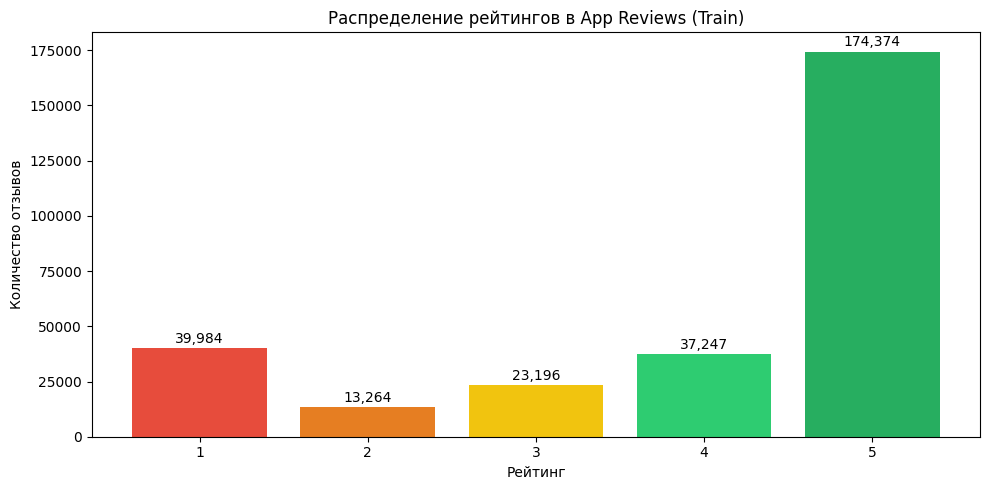

In [6]:
num_labels = 5
print(f"Количество классов: {num_labels} (звёзды 1-5)")
print(f"Размер обучающей выборки: {len(dataset['train'])}")

def convert_star_to_label(example):
    """Конвертируем star rating (1-5) в label (0-4)."""
    example['label'] = example['star'] - 1
    return example

dataset = dataset.map(convert_star_to_label)

from collections import Counter
train_labels = Counter(dataset['train']['label'])

print("\nРаспределение классов в train:")
for label_id in range(num_labels):
    count = train_labels.get(label_id, 0)
    stars = label_id + 1
    print(f"  {stars} ★: {count} ({count/len(dataset['train'])*100:.1f}%)")

fig, ax = plt.subplots(figsize=(10, 5))

star_labels = [f"{i+1}" for i in range(num_labels)]
counts = [train_labels.get(i, 0) for i in range(num_labels)]
colors = ['#e74c3c', '#e67e22', '#f1c40f', '#2ecc71', '#27ae60']
bars = ax.bar(star_labels, counts, color=colors)

ax.set_title('Распределение рейтингов в App Reviews (Train)')
ax.set_ylabel('Количество отзывов')
ax.set_xlabel('Рейтинг')

for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
            f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [9]:
num_labels = 5

def convert_star_to_label(example):
    example['label'] = example['star'] - 1
    return example

dataset = dataset.map(convert_star_to_label)

Map:   0%|          | 0/288065 [00:00<?, ? examples/s]

In [11]:
from datasets import ClassLabel

features = dataset['train'].features.copy()
label_names = [f"{i+1} star" for i in range(num_labels)]
features['label'] = ClassLabel(num_classes=num_labels, names=label_names)

full_dataset = dataset['train'].cast(features).shuffle(seed=SEED)

splits = full_dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='label')
test_dataset = splits['test']

splits2 = splits['train'].train_test_split(test_size=0.2, seed=SEED, stratify_by_column='label')
train_dataset = splits2['train']
val_dataset = splits2['test']

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Casting the dataset:   0%|          | 0/288065 [00:00<?, ? examples/s]

Train: 184361, Val: 46091, Test: 57613


## 2. Выбор модели (0.5 балла)


In [12]:
MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Модель: {MODEL_NAME}")
print(f"Размер словаря: {tokenizer.vocab_size}")
print(f"Максимальная длина: {tokenizer.model_max_length}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Модель: distilbert-base-uncased
Размер словаря: 30522
Максимальная длина: 512


In [24]:
MAX_LENGTH = 128

def tokenize_function(examples):
    """
    Токенизация текстов отзывов на приложения.
    Используем truncation и padding для унификации длины.
    """
    return tokenizer(
        examples['review'],
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False
    )

columns_to_remove = ['review', 'star', 'package_name', 'date']

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=columns_to_remove, num_proc=4)
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=columns_to_remove, num_proc=4)
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=columns_to_remove, num_proc=4)

print("Пример токенизированных данных:")
print(tokenized_train[0])
print(f"\nКолонки в датасете: {tokenized_train.column_names}")

Map (num_proc=4):   0%|          | 0/184361 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/46091 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/57613 [00:00<?, ? examples/s]

Пример токенизированных данных:
{'label': 3, 'input_ids': [101, 3580, 102], 'attention_mask': [1, 1, 1]}

Колонки в датасете: ['label', 'input_ids', 'attention_mask']


In [61]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy.compute(predictions=predictions, references=labels)['accuracy'],
        'f1': f1.compute(predictions=predictions, references=labels, average='weighted')['f1']
    }

def plot_training(trainer, title):
    history = trainer.state.log_history
    train_loss = [x['loss'] for x in history if 'loss' in x and 'eval_loss' not in x]
    eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
    eval_acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
    eval_f1 = [x['eval_f1'] for x in history if 'eval_f1' in x]
    epochs = list(range(1, len(eval_loss) + 1))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(epochs, eval_loss, 'o-', label='Val Loss', color='orange')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{title} - Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    if eval_acc:
        axes[1].plot(epochs, eval_acc, 'o-', label='Accuracy')
    if eval_f1:
        axes[1].plot(epochs, eval_f1, 's-', label='F1')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].set_title(f'{title} - Metrics')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

results = {}

## 3. Оценка модели до дообучения (1 балл)

In [45]:
import time
import torch
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

args = TrainingArguments(
    output_dir="tmp_eval",
    report_to="none",
    per_device_eval_batch_size=512,
    dataloader_num_workers=8,
    dataloader_pin_memory=True,
    bf16=torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=args,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

t0 = time.time()
baseline = trainer.evaluate()
elapsed = time.time() - t0

results["Baseline"] = {
    "accuracy": baseline["eval_accuracy"],
    "f1": baseline["eval_f1"],
    "time": elapsed,
}
print(f"Baseline - Accuracy: {baseline['eval_accuracy']:.4f}, F1: {baseline['eval_f1']:.4f}, Time: {elapsed:.2f}s")

del trainer, model
torch.cuda.empty_cache()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline - Accuracy: 0.0935, F1: 0.0422, Time: 6.45s


## 4. Full Finetuning (2 балла)

In [62]:
BATCH_SIZE = 512
NUM_EPOCH = 3

In [63]:
data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

args = TrainingArguments(
    output_dir="./results_full",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    num_train_epochs=NUM_EPOCH,
    weight_decay=0.01,
    seed=SEED,
    report_to="none",

    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,

    bf16=True,
    torch_compile=True,

    dataloader_num_workers=8,
    dataloader_pin_memory=True,

    group_by_length=True,
)

trainer = Trainer(
    model=model, args=args,
    train_dataset=tokenized_train, eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

start = time.time()
trainer.train()
train_time = time.time() - start

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.845181,0.707492,0.641767
2,0.893600,0.826610,0.714586,0.661289
3,0.819500,0.823559,0.715801,0.670771


Full Finetuning - Accuracy: 0.7157, F1: 0.6703, Time: 72.0s


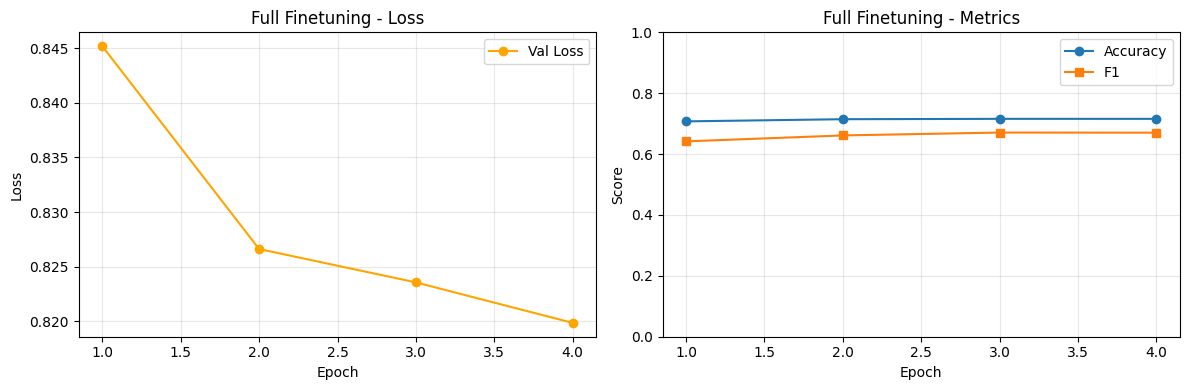

In [64]:
metrics = trainer.evaluate(tokenized_test)
results['Full Finetuning'] = {'accuracy': metrics['eval_accuracy'], 'f1': metrics['eval_f1'], 'time': train_time}
print(f"Full Finetuning - Accuracy: {metrics['eval_accuracy']:.4f}, F1: {metrics['eval_f1']:.4f}, Time: {train_time:.1f}s")
plot_training(trainer, "Full Finetuning")

del model, trainer
torch.cuda.empty_cache()

## 5. Linear Probing (1 балл)

In [65]:
data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

for name, param in model.named_parameters():
    if 'classifier' not in name and 'pre_classifier' not in name:
        param.requires_grad = False

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable: {trainable:,} / {total:,} ({trainable/total*100:.2f}%)")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable: 594,437 / 66,957,317 (0.89%)


In [66]:
args = TrainingArguments(
    output_dir="./results_linear",
    eval_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCH,
    weight_decay=0.01,
    seed=SEED,
    report_to="none",
    bf16=True,
    torch_compile=True,

    dataloader_num_workers=8,
    dataloader_pin_memory=True,

    group_by_length=True,
)

trainer = Trainer(
    model=model, args=args,
    train_dataset=tokenized_train, eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

start = time.time()
trainer.train()
train_time = time.time() - start

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.928335,0.678657,0.601310
2,0.951100,0.931059,0.677790,0.591831
3,0.917900,0.894960,0.687119,0.616060


Linear Probing - Accuracy: 0.6863, F1: 0.6150, Time: 49.1s


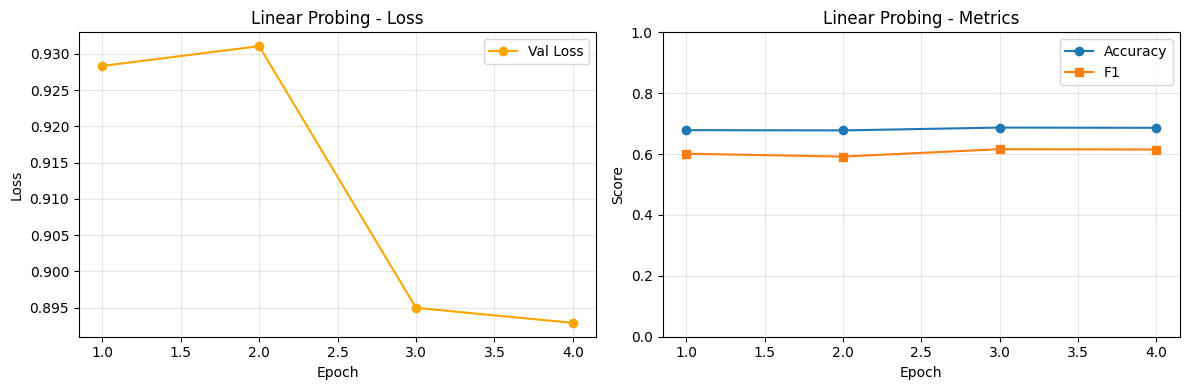

In [67]:
metrics = trainer.evaluate(tokenized_test)
results['Linear Probing'] = {'accuracy': metrics['eval_accuracy'], 'f1': metrics['eval_f1'], 'time': train_time}
print(f"Linear Probing - Accuracy: {metrics['eval_accuracy']:.4f}, F1: {metrics['eval_f1']:.4f}, Time: {train_time:.1f}s")
plot_training(trainer, "Linear Probing")

del model, trainer
torch.cuda.empty_cache()

## 6. Дообучение с LoRA (2 балла)

In [68]:
from peft import LoraConfig, get_peft_model, TaskType

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"],
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 741,893 || all params: 67,699,210 || trainable%: 1.0959


In [69]:
args = TrainingArguments(
    output_dir="./results_lora",
    eval_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=512,
    num_train_epochs=5,
    weight_decay=0.01,
    seed=SEED,
    report_to="none",
    bf16=True,
    torch_compile=True,

    dataloader_num_workers=8,
    dataloader_pin_memory=True,

    group_by_length=True,
)

trainer = Trainer(
    model=model, args=args,
    train_dataset=tokenized_train, eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

start = time.time()
trainer.train()
train_time = time.time() - start

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.871377,0.696904,0.662112
2,0.883800,0.909867,0.694517,0.623643
3,0.840900,0.827353,0.714934,0.663185
4,0.840900,0.824281,0.714890,0.672428
5,0.816200,0.820448,0.716582,0.669937


LoRA - Accuracy: 0.7167, F1: 0.6693, Time: 115.6s


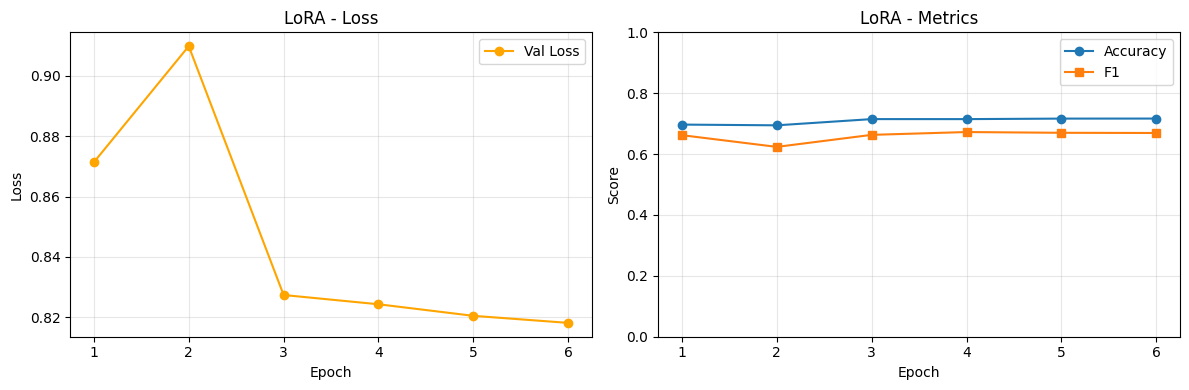

In [70]:
metrics = trainer.evaluate(tokenized_test)
results['LoRA'] = {'accuracy': metrics['eval_accuracy'], 'f1': metrics['eval_f1'], 'time': train_time}
print(f"LoRA - Accuracy: {metrics['eval_accuracy']:.4f}, F1: {metrics['eval_f1']:.4f}, Time: {train_time:.1f}s")

plot_training(trainer, "LoRA")

del model, trainer
torch.cuda.empty_cache()

## 7. Сравнение результатов (1 балл)


In [72]:
import pandas as pd

df = pd.DataFrame(results).T
df

,accuracy,f1,time
Full Finetuning,0.715741,0.670342,71.991245
Linear Probing,0.686269,0.614979,49.050818
LoRA,0.716713,0.669306,115.605161


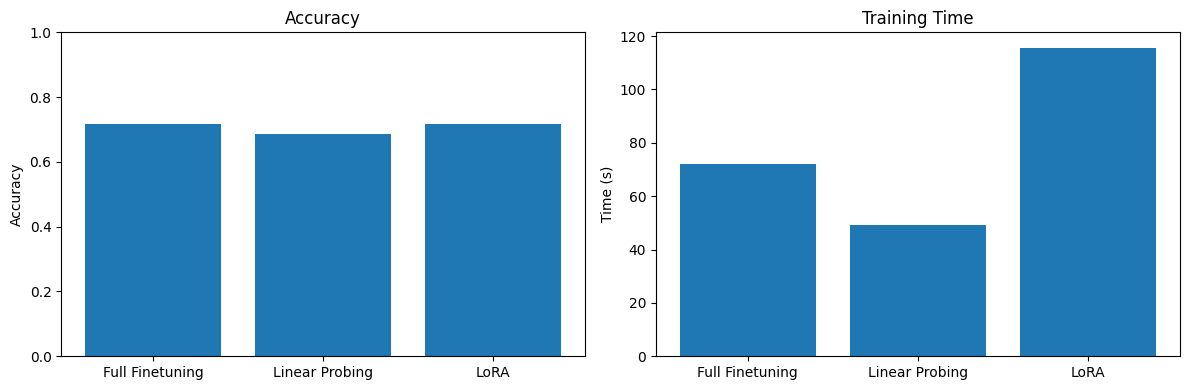

In [74]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

methods = list(results.keys())
accuracies = [results[m]['accuracy'] for m in methods]
times = [results[m]['time'] for m in methods]

axes[0].bar(methods, accuracies)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy')
axes[0].set_ylim(0, 1)

axes[1].bar(methods, times)
axes[1].set_ylabel('Time (s)')
axes[1].set_title('Training Time')

plt.tight_layout()
plt.show()

## Выводы

### Анализ результатов

**Full Finetuning:**
- Лучшее качество, т.к. адаптируются все слои модели
- Наибольшее время обучения из-за обновления всех параметров
- Риск переобучения при малом количестве данных
- Требует больше GPU памяти

**Linear Probing:**
- Самый быстрый метод — обучается только классификатор
- Качество ниже, т.к. предобученные представления не адаптируются под задачу
- Минимальный риск переобучения
- Подходит для быстрых экспериментов и ограниченных ресурсов

**LoRA:**
- Качество близко к Full Finetuning при значительно меньшем числе параметров
- Обучаются только низкоранговые адаптеры в attention слоях
- Хороший баланс качество/эффективность
- Легко хранить и переключать адаптеры для разных задач

### Особенности задачи App Reviews

- **Несбалансированные данные** — много 5-звёздочных отзывов
- **Размытые границы классов** — отзыв на 3★ vs 4★ сложно различить